In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys

sys.path.append("../..")
import numpy as np
import tensorflow as tf
from Bio import SeqIO

import tensortree

2025-05-06 15:16:35.067662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-06 15:16:35.084916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-06 15:16:35.090151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 15:16:35.103855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-06 15:16:35.720393: W tensorflow/compiler/tf2

In [ ]:
msa_file = "../data/PF00028.fasta"
tree_file = "../data/PF00028.fasta.raxml.bestTree"
alphabet = "ARNDCQEGHILKMFPSTWYV"

In [3]:
# parse fasta
import tensortree.model

leaf_names = []
seqs = []
for record in SeqIO.parse(msa_file, "fasta"):
    leaf_names.append(record.id)
    seqs.append(str(record.seq))

one_hot_leaves = tensortree.util.encode_one_hot(seqs, alphabet=alphabet+".")
# handle gaps
one_hot_leaves = one_hot_leaves[... ,:-1] + one_hot_leaves[..., -1:]/len(alphabet)
one_hot_leaves = one_hot_leaves[:, np.newaxis] # add model dimension

# create tree
tree = tensortree.TreeHandler.read(tree_file)

In [4]:
tree.branch_lengths.shape

(107, 1)

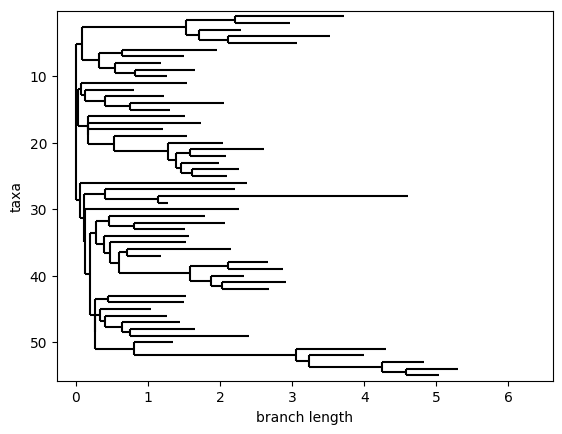

In [5]:
tree.draw(no_labels=True)

In [6]:
print("MSA depth:", len(seqs))
print("MSA width:", len(seqs[0]))
print("Tree height:", tree.height)
print("Tree nodes:", tree.num_nodes)

MSA depth: 55
MSA width: 129
Tree height: 12
Tree nodes: 108


In [7]:
# set 10 identical models by copying the branch 
# leaves and rate matrix will be broadcasted
num_models = 10

branch_lengths = np.repeat(tree.branch_lengths, num_models, -1)

# add length dimension
branch_lengths = branch_lengths[..., np.newaxis].astype(np.float32)

### TensorFlow

In [8]:
tensortree.set_backend("tensorflow")

In [9]:
R, pi = tensortree.substitution_models.jukes_cantor(d = len(alphabet))
rate_matrix = tensortree.model.backend.make_rate_matrix(R, pi).numpy()
rate_matrix = rate_matrix[tf.newaxis, :, tf.newaxis,...] # add node and length dimensions

2025-05-06 15:16:37.119363: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-05-06 15:16:37.119572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21909 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
#wrap in tf function for speed
@tf.function
def loglik():
    transition_probs = tensortree.backend.make_transition_probs(
        rate_matrix, 
        branch_lengths
    )
    return tensortree.model.loglik(
        one_hot_leaves, 
        tree, 
        transition_probs,
        tf.math.log(pi),
        leaf_names, 
        leaves_are_probabilities=True
    )

In [11]:
_=loglik() # compile

2025-05-06 15:16:38.822246: I tensorflow/core/util/cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x60a9bc8140b0


In [12]:
%%timeit -n 10
    _=loglik()

2.62 ms ± 108 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Pytorch

In [13]:
tensortree.set_backend("pytorch")

In [14]:
import torch 

R, pi = tensortree.substitution_models.jukes_cantor(d = len(alphabet))
rate_matrix_torch = tensortree.model.backend.make_rate_matrix(R, pi).to("cuda")
rate_matrix_torch = rate_matrix_torch[None, :, None,...] # add node and length dimensions

pi_torch = torch.tensor(pi, device="cuda")
one_hot_leaves_torch = torch.tensor(one_hot_leaves, device="cuda")
branch_lengths_toch = torch.tensor(branch_lengths, device="cuda")

In [15]:
def loglik_torch():
    transition_probs_torch = tensortree.backend.make_transition_probs(
        rate_matrix_torch, 
        branch_lengths_toch
    )
    L = tensortree.model.loglik(
        one_hot_leaves_torch, 
        tree, 
        transition_probs_torch,
        torch.log(pi_torch),
        leaf_names, 
        leaves_are_probabilities=True
    )
    return L

In [16]:
loglik_torch()

tensor([[-132.2106, -157.4840, -152.3321,  ..., -158.4232, -106.2271,
         -144.2870],
        [-132.2106, -157.4840, -152.3321,  ..., -158.4232, -106.2271,
         -144.2870],
        [-132.2106, -157.4840, -152.3321,  ..., -158.4232, -106.2271,
         -144.2870],
        ...,
        [-132.2106, -157.4840, -152.3321,  ..., -158.4232, -106.2271,
         -144.2870],
        [-132.2106, -157.4840, -152.3321,  ..., -158.4232, -106.2271,
         -144.2870],
        [-132.2106, -157.4840, -152.3321,  ..., -158.4232, -106.2271,
         -144.2870]], device='cuda:0')

In [17]:
%%timeit -n 10
loglik_torch()

4.36 ms ± 34.4 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
